### Preprocessing LARRY data for the interpolation (day 4 holdout) task

This notebook reprocesses the LARRY dataset as shown in the **[Notebook 2a](https://github.com/gifford-lab/prescient-analysis/blob/master/notebooks/02a-weinreb2020-interpolation-data.ipynb)** made available by the authors of PRESCIENT.

In [1]:
%load_ext nb_black

import prescient_nb as prescient

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


<IPython.core.display.Javascript object>

#### Load data as `adata`.

I've built the preprocessing functions into the following module, which can be downloaded using [`pip install PRESCIENT.nb`](https://pypi.org/project/PRESCIENT.nb/). The `Weinreb2020` class mediates the functions in this notebook and is outlined as follows:

The data loaded from `data_dir` can be downloaded at the following: [link](https://github.com/AllonKleinLab/paper-data/blob/master/Lineage_tracing_on_transcriptional_landscapes_links_state_to_fate_during_differentiation/README.md)


```python
class _format_Weinreb2020:
    
    def __init__(self, data_dir):
        
        self._X_path = os.path.join(data_dir, "counts_matrix_in_vitro.npz")
        self._clonal_path = os.path.join(data_dir, "clone_annotation_in_vitro.npz")
        self._obs_path = os.path.join(data_dir, "cell_metadata_in_vitro.txt")
        self._var_path = os.path.join(data_dir, "gene_names_in_vitro.txt")
        self._X_spring_path = os.path.join(data_dir, "coordinates_in_vitro.txt")
        self.data_dir = data_dir
        self.outfilename = "Weinreb2020.LARRY.imputation_task.inputs"
        
    def create_adata(self, verbose=True):
        
        self.adata = anndata.AnnData(scipy.sparse.load_npz(self._X_path).tocsc())
        self.adata.obs = pd.read_csv(self._obs_path, sep="\t")
        self.adata.var = pd.read_csv(self._var_path, header=None, names=['gene_id'])
        self.adata.obsm['X_spring'] = np.loadtxt(self._X_spring_path, 
                                                 dtype=float).reshape(self.adata.shape[0], 2)
        self.adata.obsm["X_clone"] = scipy.sparse.load_npz(self._clonal_path).tocsc()
        
        if verbose:
            print(self.adata)
        
    def preprocess(self, signature_genes, return_adata=False):
        
        ct.rna.filter_static_genes(self.adata)
        self.adata = ct.rna.remove_correlated_genes(self.adata, signature_genes)
        if return_adata:
            return self.adata
        
    def prepare_imputation_task(self,
                                split=True,
                                column="Time point",
                                test_criteria=4,
                                n_pcs=50,
                                n_neighbors=30,
                                n_umap_components=2,
                                umap_metric="euclidean",
                                verbose=True,
                                save=True):

        self.transformer = ct.tl.reduce_adata(self.adata, 
                                        split,
                                        column,
                                        test_criteria,
                                        n_pcs,
                                        n_neighbors,
                                        n_umap_components,
                                        umap_metric,)
        
        self.adata = self.transformer.adata
        self.adata.uns['pca'] = self.transformer._pca_reducer
        self.adata.uns['umap'] = self.transformer._umap_reducer

        if save:
            _save_adata_incompatible_components(adata=self.adata, 
                                            uns_keys=["pca", "umap"], 
                                            directory=self.outfilename)
                        
    def dimension_reduction(self):
        
        self.adata = ct.tl.quickDR(self.adata)
    
    def plot_celltypes(self):
        
        self.adata.obs["train"] = self.transformer.train
        
        return _plot_celltypes_test_train(self.adata)
    
    def plot_density(self):
        
        return _plot_density(self.adata)
            
    def write(self, filename=False):
        
        if filename:
            self.outfilename = filename
        _save_adata_incompatible_components(adata=self.adata, 
                                            uns_keys=["pca", "umap"], 
                                            directory=self.outfilename)
```


#### some additional notes:
1. For brevity and readability, I've removed the documentation from the code shown above. For more information on each function, please see the source code directly. 

2. The comparable outputs of the data preprocessed by the authors of PRESCIENT is available here: [link](https://www.dropbox.com/sh/aa17iamx2yx58l6/AADSd4XHkpJ-Jz-MhYK53-O0a/data/Weinreb2020_fate?dl=0&subfolder_nav_tracking=1). 

3. The dependencies of this module of `prescient_nb` are [anndata](https://pypi.org/project/anndata/), [scipy](https://pypi.org/project/scipy/), and [cell-tools](https://pypi.org/project/cell-tools/).

4. Eventually, I'll wrap all of this analysis and the functions that come from `PRESCIENT.nb` into an scdiffeq helper package of sorts to make for a more seemless/accessible reproducibility experience. 

4. Please contact [Michael Vinyard](mailto:mvinyard@broadinstitute.org).

In [2]:
data = prescient.util.Weinreb2020("../inputs/")
data.create_adata()

AnnData object with n_obs × n_vars = 130887 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    var: 'gene_id'
    obsm: 'X_spring', 'X_clone'


<IPython.core.display.Javascript object>

#### Filter genes correlated with cell-cycle genes:

Given a list of signature_genes, the following function `data.preprocess(signature_genes)`  identifies highly-variable genes and then removes genes from those highly-variable genes that are correlated with the provided list, `cell_cycle_genes`:

One thing the authors do here that I don't totally understand and likely comes from the Weinreb paper is that they select (seemingly at random) 2447 / 2497 of the resulting genes. 

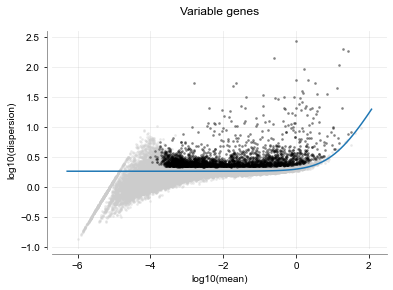

2515 variable genes identified

Removing genes correlated with the expression of those provided...


From 2515 genes, 18 genes were removed leaving 2497 genes.

AnnData object with n_obs × n_vars = 130887 × 2497
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    var: 'gene_id', 'highly_variable'
    uns: 'highly_variable_genes_idx'
    obsm: 'X_spring', 'X_clone'


<IPython.core.display.Javascript object>

In [3]:
cell_cycle_genes = [
    "Ube2c",
    "Hmgb2",
    "Hmgn2",
    "Tuba1b",
    "Ccnb1",
    "Tubb5",
    "Top2a",
    "Tubb4b",
]

data.preprocess(signature_genes=cell_cycle_genes)

#### Day 4 holdout data preprocessing

The important thing to note here is that the StandardScaler(), PCA(), and UMAP() parameters are fit using the data from **day 2** and **day 6 (training set)** but **not day 4 (test set)**. From the PRESCIENT notebook:
> Since we are holding out the middle time point, we will not use it for fitting the data transformation

In practice, we transform each subset of data using the parameters based on the training set. This means using `.fit_transform()` on the training set and `.transform()` on the test set. 

In [4]:
data.prepare_imputation_task()

Scaling adata.X using StandardScaler

PCA: n_components=50

UMAP: n_components=2, n_neighbors=30, umap_metrics=euclidean


AnnData and associated objects were saved to: Weinreb2020.LARRY.imputation_task.inputs/
AnnData object with n_obs × n_vars = 130887 × 2497
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    var: 'gene_id', 'highly_variable'
    uns: 'highly_variable_genes_idx'
    obsm: 'X_spring', 'X_clone', 'X_scaled', 'X_pca', 'X_umap'


<IPython.core.display.Javascript object>

### Plot processed data for `interpolation` experiment

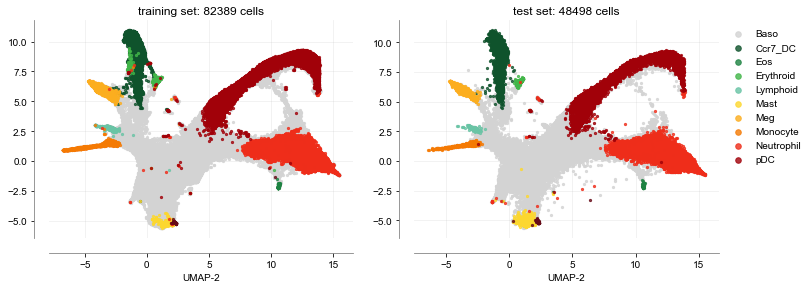

<IPython.core.display.Javascript object>

In [5]:
data.plot_celltypes()

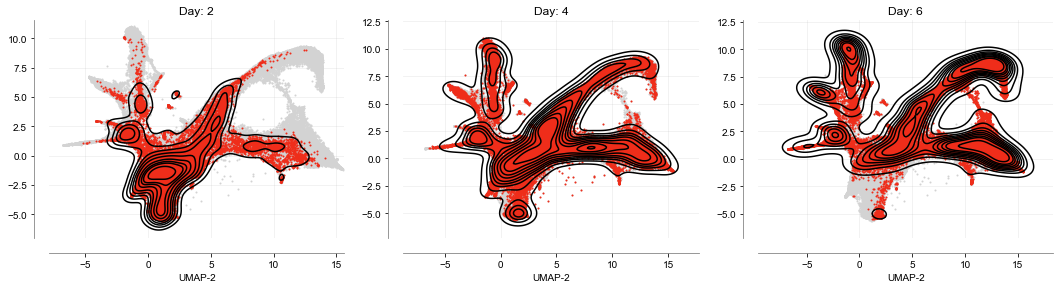

<IPython.core.display.Javascript object>

In [6]:
data.plot_density()

### Proliferation

*This part is still in progress and this notebook will be updated with these details upon completion*.